In [53]:
# importations 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import jieba
import jieba.analyse
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import re 
import warnings
warnings.filterwarnings('ignore')

# instructions needed to present chinese in seaborn/matplotlib libs
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)
sns.set(font=myfont.get_name())


In [2]:
# load data
data = pd.read_csv('./data/job_data.csv')

In [3]:
# a glimpse at the data 
data.head(3)

,company_city,company_geo.0.lat,company_geo.0.lon,company_name.0,company_size.0,company_type.0,description,eduLevel,job_empltype.0,job_name.0,job_salary.0,job_type,job_welfare.0.0,job_welfare.0.1,job_welfare.0.2,job_welfare.0.3,job_welfare.0.4,workExperienced.0
0,北京,39.904883,116.459991,北京中天方木教育科技有限公司,100-499人,民营,职位描述【数据分析师】1、岗位职责：1.协助经理整理金融数据分析报告，以及每日早间报告2.上...,不限,全职,市场数据分析师助理,8K-15K,"咨询/顾问/调研/数据分析,数据分析师",五险一金,周末双休,绩效奖金,全勤奖,带薪年假,不限
1,北京-朝阳区,39.903383,116.473439,尼尔森网联媒介数据服务有限公司北京分公司,100-499人,合资,职位要求：1. 大学本科及以上学历，计算机及相关专业、广告、新闻、统计专业优先；2. 一年以...,大专,全职,数据分析师助理,4K-6K,"市场,市场调研与分析",五险一金,带薪年假,补充医疗保险,定期体检,节日福利,不限
2,北京-东城区,39.895049,116.438960,北京万向通汇投资有限公司,100-499人,合资,北京万向天乾科技有限公司隶属北京万向联合控股集团，目前北京有五家直营公司，全国范围内达50家...,本科,全职,金融数据分析师,8K-15K,"证券/期货/投资管理/服务,证券分析/金融研究",不加班,每年多次调薪,五险一金,年终分红,全勤奖,不限


# Preprocessing

### salary

In [4]:
#tranform job_salary into three seperate features : mean_salary,max_salary and min_salary
max_salary = []
min_salary =[]
mean_salary = []
# match int or float number
pattern = re.compile('\d+\.?[0-9]?')
for i in range(len(data)):
    salary = data.iloc[i]['job_salary.0']
    result = re.findall(pattern,salary)
    if result:
        # 8k-10k
        if len(result) == 2:
            max_salary.append(float(result[1]))
            min_salary.append(float(result[0]))
            mean_salary.append((float(result[0])+float(result[1]))/2)
        elif len(result) == 1: 
            # 1k 以下
            max_salary.append(float(result[0]))
            min_salary.append(float(result[0]))
            mean_salary.append(float(result[0]))
    else:
        #工资面议
        max_salary.append(np.nan)
        min_salary.append(np.nan)
        mean_salary.append(np.nan)

data['max_salary'] = max_salary
data['min_salary'] = min_salary
data['mean_salary'] = mean_salary

In [5]:
data.drop('job_salary.0',axis=1,inplace=True)

### welfare

In [6]:
# tranform welfare features into dummy factors
welfare_list = ['job_welfare.0.0','job_welfare.0.1','job_welfare.0.2','job_welfare.0.3','job_welfare.0.4']
welfare = []
# get all the unique welfares
for w in welfare_list:
    temp = list(data[w])
    for t in temp:
        welfare.append(t)
welfare = set(welfare)

In [7]:
#discare nan
welfare.discard(np.nan)
welfare

{'14薪',
 '不加班',
 '五险一金',
 '交通补助',
 '住房补贴',
 '健身俱乐部',
 '免息房贷',
 '免费班车',
 '全勤奖',
 '创业公司',
 '加班补助',
 '包住',
 '包吃',
 '员工旅游',
 '周末双休',
 '定期体检',
 '带薪年假',
 '年底双薪',
 '年终分红',
 '弹性工作',
 '房补',
 '无试用期',
 '每年多次调薪',
 '绩效奖金',
 '股票期权',
 '节日福利',
 '补充医疗保险',
 '通讯补贴',
 '采暖补贴',
 '餐补',
 '高温补贴'}

In [8]:
welfare_dict = {}
for w in welfare:
    welfare_dict[w] = []

In [9]:
#if the job has one type welfare, set label as 1 else 0
for i in range(len(data)):
    w1 = data['job_welfare.0.0'][i]
    w2 = data['job_welfare.0.1'][i]
    w3 = data['job_welfare.0.2'][i]
    w4 = data['job_welfare.0.3'][i]
    w5 = data['job_welfare.0.4'][i]
    w_list = [w1,w2,w3,w4,w5]
    for w in welfare_dict:
        if w in w_list:
            welfare_dict[w].append(1)
        else:
            welfare_dict[w].append(0)

In [10]:
for key,value in welfare_dict.items():
    data[key]=value

In [11]:
data.drop(welfare_list,inplace=True,axis=1)

### city

In [12]:
# e.g. transform 北京-朝阳区 into 北京
data['company_city'] = data['company_city'].apply(lambda x: x.split('-')[0])

### job type

In [13]:
# simplifies the job type, remove precise job name but maintain the category
data['job_type'] = data['job_type'].apply(lambda x: x.split(',')[0])

In [14]:
data['job_type'].value_counts().head(10)

咨询/顾问/调研/数据分析    1474
软件/互联网开发/系统集成    1007
证券/期货/投资管理/服务     804
互联网产品/运营管理        444
客服/售前/售后技术支持      258
销售行政/商务           234
IT运维/技术支持         136
销售业务              136
市场                129
行政/后勤/文秘          127
Name: job_type, dtype: int64

### description

#### wordcloud

In [15]:
# wanted skills
skill_keywords = ['python','r','sql','excel','knime','hadoop','tableau','sas','spark','hive','spark','数据可视化',
                  '统计','matlab','c\+\+','c','java','spss','大数据','编程','机器学习',
                  '算法','数据库','bi','商业智能','ppt','office','办公软件','nosql','mongodb',
                  'mysql','爬虫','数学','建模','numpy',
                 'skilearn','linux','pandas','machine learning','big data']

# concate all the description
def concate_descrip(df):
    text = ''
    count = 0
    for i in range(len(df)):
        text += df.iloc[i]['description']
        count += 1
    print('finish concating {} jobs'.format(str(count)))
    return text

# splitting text 
# the cutting mode 
def cut_text(text,mode='Accuracy'):
    if mode == 'Accuracy':
        word_list = jieba.cut(text,cut_all=False)
    elif mode == 'Full':
        word_list = jieba.cut(text, cut_all=True)
    elif mode =='HMM':
        word_list = jieba.cut(text,cut_all=False, HMM=True)
    elif mode == 'Search Engine':
        word_list = jieba.cut_for_search(text)
    return ' '.join(word_list)

# function to plot wordcloud
% matplotlib inline
def plot_wordcloud(text,width=800,height=800,figsize=(12,6),max_words=50, stopwords=STOPWORDS):
    wc = WordCloud(font_path = 'WenQuanYi Zen Hei Mono.ttf',width=width,height=height,max_words=max_words,
                   random_state=23,background_color='white',
                   stopwords=stopwords,collocations=False).generate(text)
    # show generated image 
    plt.figure(figsize= figsize)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\JASPER\AppData\Local\Temp\jieba.cache


finish concating 5427 jobs


Loading model cost 1.583 seconds.
Prefix dict has been built succesfully.


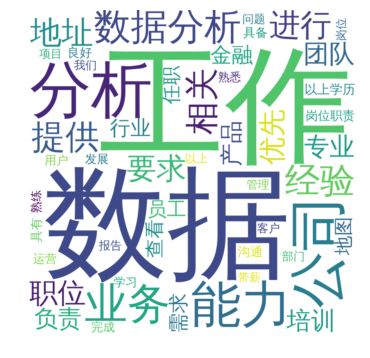

In [16]:
# extract keywords in description without processing
text = concate_descrip(data)
cutted_text = cut_text(text)
plot_wordcloud(cutted_text)

In [17]:
# extract top 100 keywords to see if there are meanless words
tags = jieba.analyse.extract_tags(cutted_text,topK=100)
print('/'.join(tags))

数据/数据分析/工作/分析/能力/地址/职位/经验/公司/业务/岗位职责/优先/以上学历/团队/培训/带薪/提供/相关/专业/任职/员工/五险/查看/负责/地图/要求/沟通/一金/数据挖掘/熟练/岗位/运营/用户/金融/进行/具备/需求/晋升/薪资/良好/产品/熟悉/福利/底薪/行业/学习/本科/客户/完成/SQL/大专/双休/提成/报告/挖掘/责任心/具有/较强/建模/统计/以上/管理/部门/项目/00/年终奖/30/软件/梦想/统计学/朝阳区/北京市/待遇/大厦/入职/福利待遇/分析师/发展/计算机/账户/数学/使用/补贴/逻辑思维/免费/操作/数据库/面试/机会/技术/模型/整理/优化/工具/能够/经理/问题/报表/支持/及时


In [18]:
useless_word= ['工作','能力','地址','职位','公司','岗位职责','以上学历','提供','任职','员工','查看','地图',
                '要求','岗位','进行','具备','薪资','行业','完成','具有','良好','较强','以上','部门','项目','00','30',
                '福利待遇','福利','使用','免费','面试','机会','能够','支持','及时','分析','相关','问题','工具']

In [19]:
# add those useless word into stopwords in order to filter them out
stopwords = set(STOPWORDS)
for s in useless_word:
    stopwords.add(s)

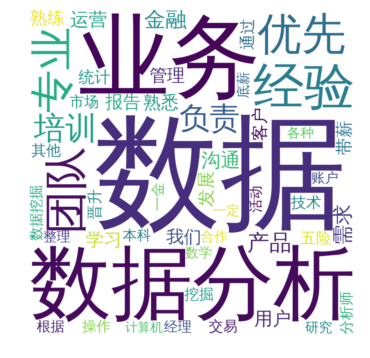

In [21]:
plot_wordcloud(cutted_text,stopwords = stopwords)

In [22]:
# only want to focus on the skills that employer wants
# problem about 机器学习
def extract_skills(data,skill_keywords):
    all_skills = []
    for i in range(len(data)):
        text = data.iloc[i]['description']
        for skill in skill_keywords:
            pattern = re.compile(skill)
            r = re.findall(pattern,text)
            if r:
                all_skills.append(skill)
    return ' '.join(all_skills)
            

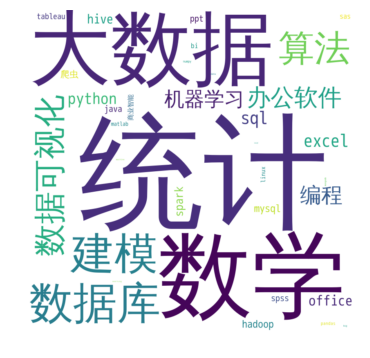

In [23]:
# to see which skills occurs most frequently
plot_wordcloud(extract_skills(data,skill_keywords))

In [24]:
# transform each skills as dummy factors
skill_dict ={}
for s in skill_keywords:
    skill_dict[s.upper()] = [0]*len(data)

for i in range(len(data)):
    des = data['description'][i]
    for skill in skill_keywords:
            pattern = re.compile(skill)
            r = re.findall(pattern,des)
            if r:
                skill_dict[skill.upper()][i] = 1

for key,value in skill_dict.items():
    data[key] = value

In [25]:
# check if there are skills not mentioned at all
for skill in skill_keywords:
    s = data[skill.upper()].sum()
    if s == 0:
        print(skill)

knime
skilearn


In [28]:
data.head(3)

,company_city,company_geo.0.lat,company_geo.0.lon,company_name.0,company_size.0,company_type.0,description,eduLevel,job_empltype.0,job_name.0,...,MYSQL,爬虫,数学,建模,NUMPY,SKILEARN,LINUX,PANDAS,MACHINE LEARNING,BIG DATA
0,北京,39.904883,116.459991,北京中天方木教育科技有限公司,100-499人,民营,职位描述【数据分析师】1、岗位职责：1.协助经理整理金融数据分析报告，以及每日早间报告2.上...,不限,全职,市场数据分析师助理,...,0,0,0,0,0,0,0,0,0,0
1,北京,39.903383,116.473439,尼尔森网联媒介数据服务有限公司北京分公司,100-499人,合资,职位要求：1. 大学本科及以上学历，计算机及相关专业、广告、新闻、统计专业优先；2. 一年以...,大专,全职,数据分析师助理,...,0,0,0,0,0,0,0,0,0,0
2,北京,39.895049,116.438960,北京万向通汇投资有限公司,100-499人,合资,北京万向天乾科技有限公司隶属北京万向联合控股集团，目前北京有五家直营公司，全国范围内达50家...,本科,全职,金融数据分析师,...,0,0,0,0,0,0,0,0,0,0


# basic virsulizations

In [29]:
def bar_plot(df,target,num_x,hue = None,ascending = False,figsize=(12,4)):
    '''
    function to plot bar chart
    parameters:
        series: input data (series type)
        target: target feature
        num_x: number of bars
        hue: hue parameter in sns.barplot()
        ascending: ascending parameter in sorting
    '''
    plt.figure(figsize=figsize)
    t = df[target].value_counts().sort_values(ascending=ascending).head(num_x)
    if hue != None:
        d = df[df[target].apply(lambda x: x in list(t.index))][[target,hue]]
        d['count'] = [1]*len(d)
        sns.barplot(x=target,y='count',hue=hue,data=d,estimator=sum,order=list(t.index),palette='Paired')
    else:
        d = df[df[target].apply(lambda x: x in list(t.index))][[target]]
        d['count'] = [1]*len(d)
        sns.barplot(x=target,y='count',hue=hue,data=d,estimator=sum,order=list(t.index),palette='Paired')

### job number

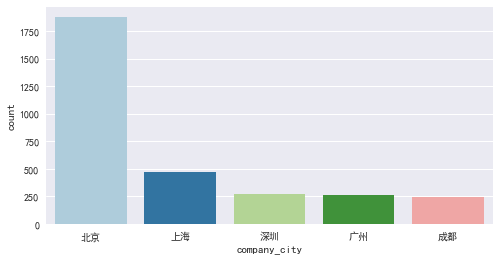

In [30]:
bar_plot(data,'company_city',5,figsize=(8,4))

### company size

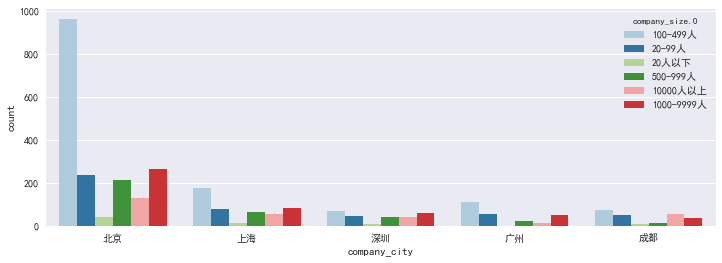

In [31]:
'''
plot bar chart to show the number of jobs in the first several cities with respect to the company size
'''
bar_plot(data,'company_city',5,hue='company_size.0')

### company type

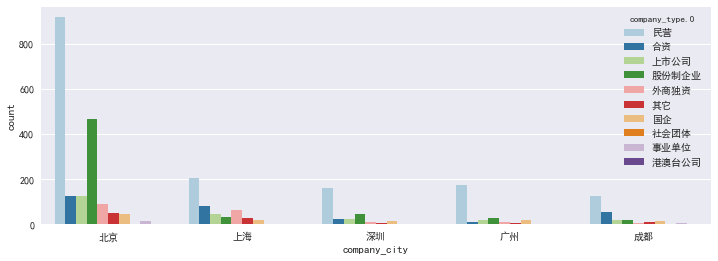

In [32]:
bar_plot(data,'company_city',5,hue='company_type.0')

### salary

In [33]:
def plot_city_salary(data,feature2='mean_salary',threshold=100,figsize=(12,4)):
    '''
    function to plot mean salary of every city
    parameter:
        data: input data (df)
        feature2: second features, choose from mean_salary,max_salary,min_salary
        threshold: thres used to avoid few jobs dominating salary level.
        figsize: paramter passed to plt.figure()
    '''
    d = data[['company_city',feature2]]
    d['count'] = [1]*len(data)
    drop_city = []
    temp = d.groupby(by=['company_city']).sum()
    for i in range(len(temp)):
        if temp['count'][i] < threshold:
            drop_city.append(temp.index[i])
    result = d.groupby(by=['company_city']).mean()
    r = result[result.index.map(lambda x:x not in drop_city)].drop('count',axis=1).reset_index()
    plt.figure(figsize=figsize)
    ax = sns.barplot(x='company_city',y='mean_salary',data = r,order=r.sort_values(by='mean_salary',ascending=False)['company_city']) 
    ax.set(xlabel='City')
    plt.show()

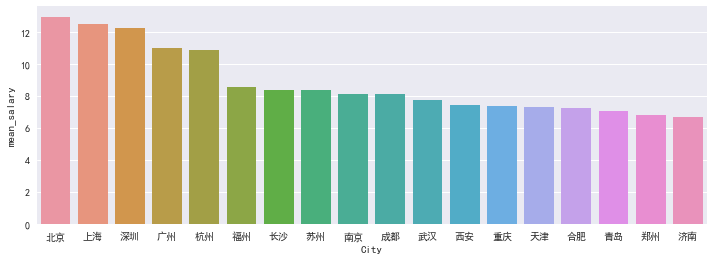

In [34]:
plot_city_salary(data,threshold=50)

### education level

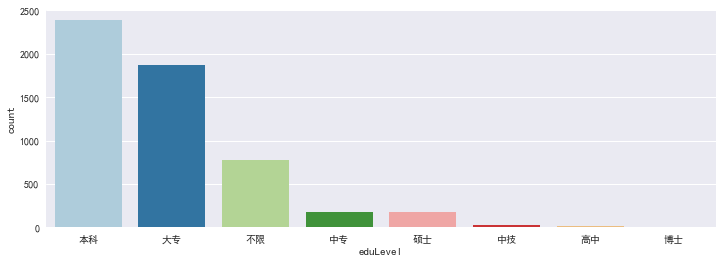

In [35]:
bar_plot(data,'eduLevel',num_x=len(data['eduLevel'].value_counts()))

### job employ type.

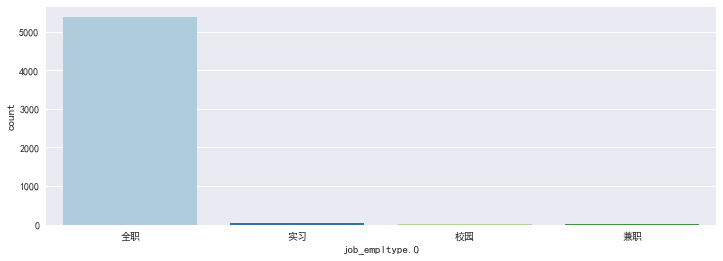

In [36]:
bar_plot(data,'job_empltype.0',num_x = len(data['job_empltype.0'].value_counts()))

### work experience

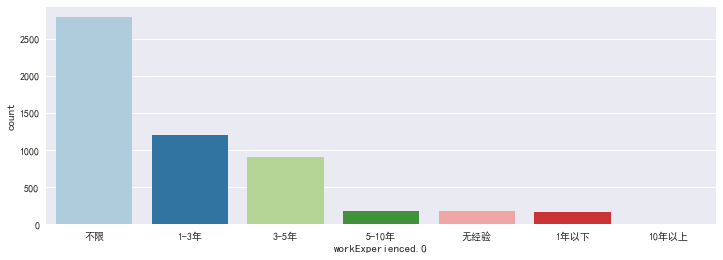

In [37]:
bar_plot(data,'workExperienced.0',num_x = len(data['workExperienced.0'].value_counts()))


### skills that affect salary

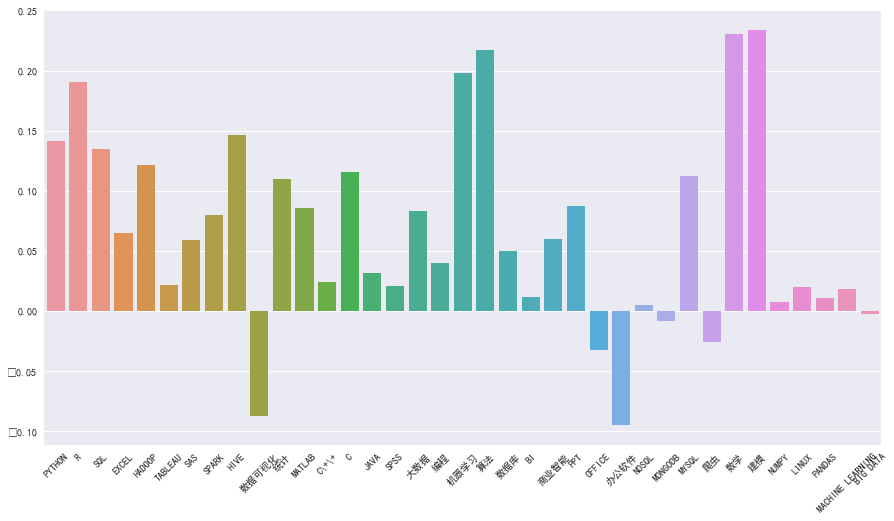

In [38]:
# some analysis about the factors affect salary 

# remove skills which did not occur at all
skill_keywords.remove('knime')
skill_keywords.remove('skilearn')

# compute correlation coefficient between each skill feature and mean salary
skill_salary_score = {}
for skill in skill_keywords:
    score  = data[skill.upper()].corr(data['mean_salary'])
    skill_salary_score[skill.upper()] = score

skill_salary_score = pd.Series(skill_salary_score)
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.barplot(x=skill_salary_score.index,y=skill_salary_score.values)

### mean salary for each skill

In [42]:
def skill_vs_salary(data,mode,skill_keywords):
    '''
    function to show the relation between skills and salary
    parameter:
        data: input df
        mode: choose from 'mean','std','box'
        if mode == 'mean', plot mean salary of those jobs that mention one certain skills
         ....
        skill_keywords: list contains the skills strings 
    '''
    skill_salary = {}
    if mode !='box':
        for skill in skill_keywords:
            pattern = skill
            index = []
            for i in range(len(data)):
                if re.findall(pattern,data['description'][i]):
                    index.append(i)
            if mode =='mean':
                salary = data.iloc[index]['mean_salary'].mean()
            elif mode =='std':
                salary = data.iloc[index]['mean_salary'].std()  
            skill_salary[skill] = salary
        skill_salary = pd.Series(skill_salary)
        plt.figure(figsize=(15,8))
        plt.xticks(rotation=45)
        sns.barplot(x=skill_salary.index,y=skill_salary.values)  
    else:
        for skill in skill_keywords:
            pattern = skill
            index = []
            for i in range(len(data)):
                if re.findall(pattern,data['description'][i]):
                    index.append(i)
            salary = list(data.iloc[index]['mean_salary'])
            skill_salary[skill] = salary
        c1=[]
        c2=[]
        for key,value in skill_salary.items():
            c1 = c1 + [key]*len(value)
            c2 = c2 + value
        df = pd.DataFrame(c2,index=c1,columns=['value'])
        plt.figure(figsize=(14,6))
        plt.xticks(rotation=45)
        sns.boxplot(x=df.index,y='value',data = df)

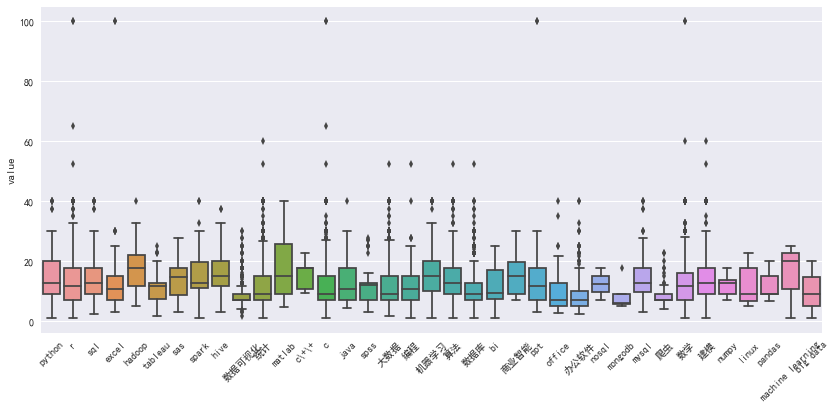

In [43]:
skill_vs_salary(data,'box',skill_keywords)

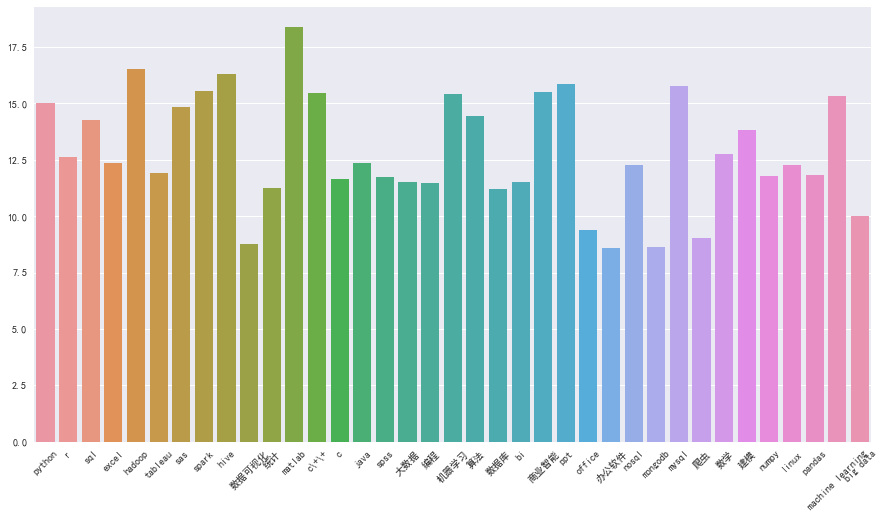

In [44]:
skill_vs_salary(data,'mean',skill_keywords)


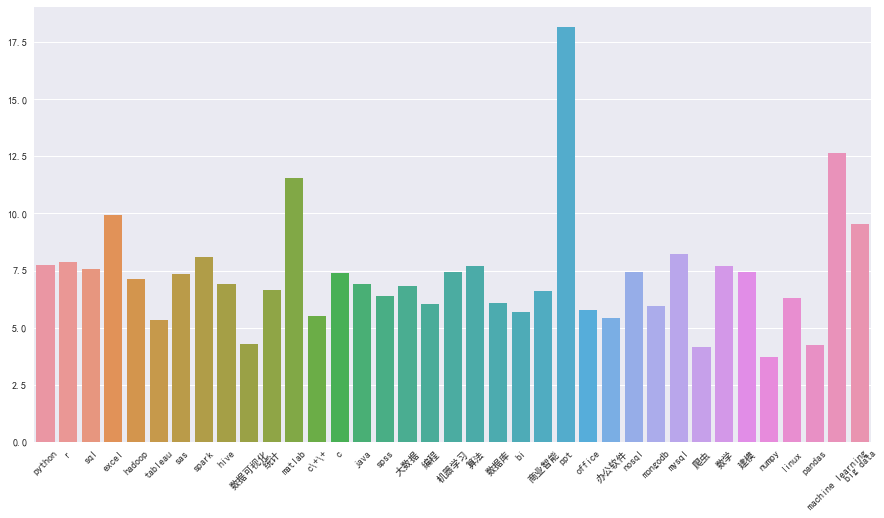

In [45]:
skill_vs_salary(data,'std',skill_keywords)